# Pre Test set

x is 224 and y is 224 and z is 11
(50176, 11)


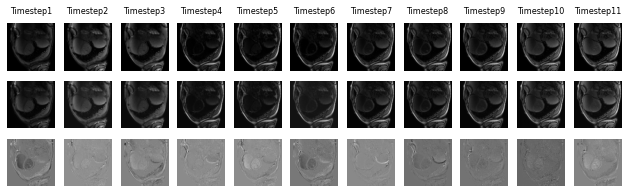

In [9]:
import numpy as np
import glob
import os
import matplotlib.pyplot as plt
from hyperspy.learn.rpca import rpca_godec, orpca
path = 'data/MOLLI_pre_dataset/test/0387056_20140423_MOLLI_3.npy'
vols = np.load(path).transpose(1, 2, 0)
x, y, z = vols.shape
print(f"x is {x} and y is {y} and z is {z}")
M = vols.reshape(x*y, z)
print(M.shape)
low, sparse, U, S, V = rpca_godec(M, rank=5)
low_matrix = low.reshape((x, y, z))
sparse_matrix = sparse.reshape((x, y, z))

fig = plt.figure(figsize=(11, 3))
title_font_size=8
title_pad = 10
for i in range(z):
    ax1 = fig.add_subplot(3, 11, 1+i)
    plt.imshow(vols[..., i], cmap='gray')
    plt.axis('off')
    ax1.set_title(f"Timestep{i+1}", fontsize=title_font_size, pad=title_pad)

    ax2 = fig.add_subplot(3, 11, 12+i)
    plt.imshow(low_matrix[..., i], cmap='gray')
    plt.axis('off')

    ax3 = fig.add_subplot(3, 11, 23+i)
    plt.imshow(sparse_matrix[..., i], cmap='gray')
    plt.axis('off')

## Test Metrics

### Original volume

#### First Eigen Component percentage

In [10]:
from scripts.utils import *
orig_path = 'data/MOLLI_pre_dataset/test'
orig_pca_changes = []
for file in sorted(glob.glob(os.path.join(orig_path, '*.npy'))):
    vols = np.load(file).transpose(1, 2, 0)
    eig_org, org_K, org_dis = pca(vols, topk=1)
    orig_pca_changes.append(org_dis)
print(f"Mean of original PCA is {np.mean(np.array(orig_pca_changes))}")

Mean of original PCA is 0.7867720274668718


#### T1 fitting

Mean of t1err is 11.072921129848977 and std is 4.963850319538608
Mean of t1err is 14.217012343355398 and std is 7.345939012337131


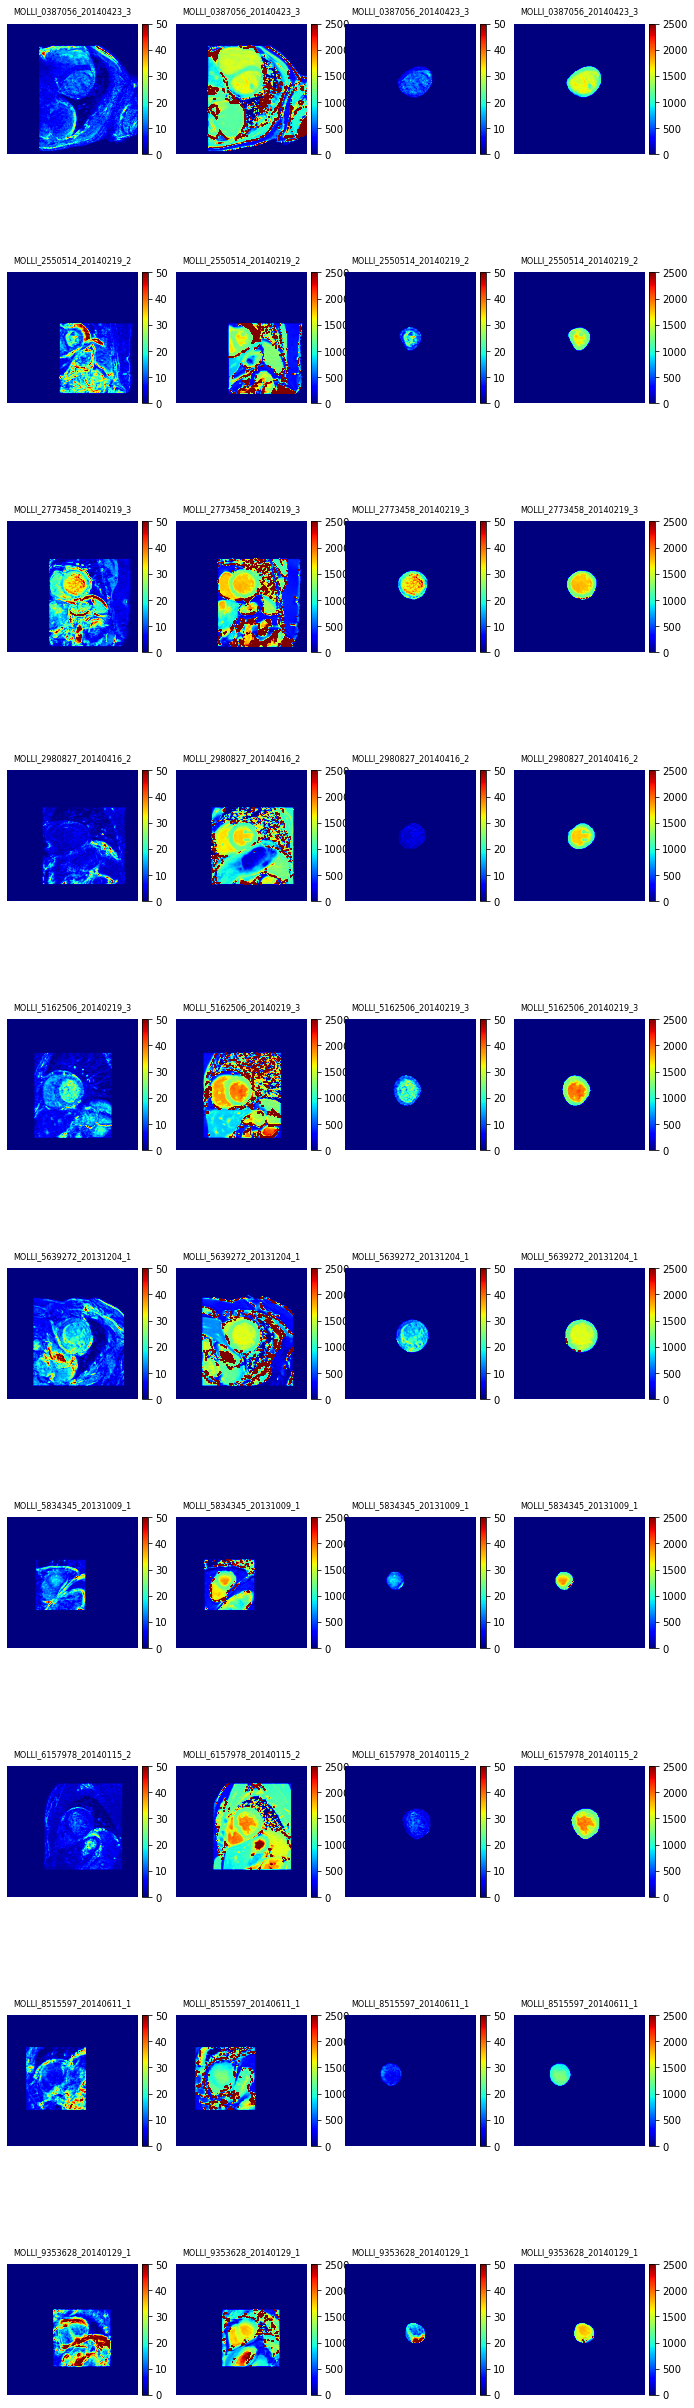

In [11]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import scipy.io
from pathlib import Path
# %matplotlib widget
path = "data/MOLLI_pre_dataset/T1_SDerr"
# print(path)
fig = plt.figure(figsize=(10,40))
title_font_size=8
title_pad = 10
orig_t1err_square_list = []
orig_t1err_heart_list = []
subject_list = []
for i, file in enumerate(sorted(glob.glob(os.path.join(path, '*.mat')))):
    subject = Path(file).stem
    subject_list.append(subject)
    fd = scipy.io.loadmat(file)
    SD_err = fd['S']
    areamask = fd['areamask']
    heartmask = fd['epi_BW']
    errmap = SD_err * areamask

    orig_t1err_square_list.append(np.mean(errmap[areamask==1]))
    fig.add_subplot(10, 4, 1+i*4)
    ax = plt.gca()
    im = ax.imshow(errmap, cmap='jet', vmin=0, vmax=50)
    ax.axis('off')
    ax.set_title(f"{subject}", fontsize=title_font_size, pad=title_pad)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)

    t1_params_pre = fd['pmap_mse']
    a = t1_params_pre[:, :, 0]
    b = t1_params_pre[:, :, 1]
    c = t1_params_pre[:, :, 2]
    t1map = c * (b - 1)
    fig.add_subplot(10, 4, 2+i*4)
    ax = plt.gca()
    im = ax.imshow(t1map, cmap='jet', vmin=0, vmax=2500)
    ax.axis('off')
    ax.set_title(f"{subject}", fontsize=title_font_size, pad=title_pad)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)

    hearterrmap = SD_err * heartmask
    heartt1map = t1map * heartmask
    orig_t1err_heart_list.append(np.mean(hearterrmap[heartmask==1]))

    fig.add_subplot(10, 4, 3+i*4)
    ax = plt.gca()
    im = ax.imshow(hearterrmap, cmap='jet', vmin=0, vmax=50)
    ax.axis('off')
    ax.set_title(f"{subject}", fontsize=title_font_size, pad=title_pad)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)

    fig.add_subplot(10, 4, 4+i*4)
    ax = plt.gca()
    im = ax.imshow(heartt1map, cmap='jet', vmin=0, vmax=2500)
    ax.axis('off')
    ax.set_title(f"{subject}", fontsize=title_font_size, pad=title_pad)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)

plt.subplots_adjust(left=0.0001,right=0.9, top=0.95, bottom=0.1,)
# plt.subplots_adjust(left=0.0001, right=0.99, top=0.9,
#                         bottom=0.1, wspace=0.01, hspace=0.2)
print(f"Mean of t1err is {np.mean(np.array(orig_t1err_square_list))} and std is {np.std(np.array(orig_t1err_square_list))}")
print(f"Mean of t1err is {np.mean(np.array(orig_t1err_heart_list))} and std is {np.std(np.array(orig_t1err_heart_list))}")
plt.savefig(f"data/MOLLI_pre_dataset/T1_SDerr/orig_t1err.png", dpi=300)

### Round 1

In [12]:
import voxelmorph_group as vxm  # nopep8
import numpy as np
import glob
import os
jacobian = vxm.losses.Jacobian().loss

In [13]:
r = 1
root = f"results/MOLLI_pre/group/rank_10_5_3/ncc/smooth/image_loss_weight1/cycle_loss_weight0.01/weight0.001/bspline/cps4_svfsteps7_svfscale1/e80/test_MOLLI_pre"
base_path = f"{root}/round{r}"

#### First Eigen Component percentage

In [14]:
path = f"{base_path}/moved"
r1_pca_changes = []
for file in sorted(glob.glob(os.path.join(path, '*.npy'))):
    vols = np.load(file).transpose(1, 2, 0)
    eig_org, org_K, org_dis = pca(vols, topk=1)
    r1_pca_changes.append(org_dis)
print(f"Mean of Round 1 PCA is {np.mean(np.array(r1_pca_changes))} and std is {np.std(np.array(r1_pca_changes))}")

Mean of Round 1 PCA is 0.793696772510596 and std is 0.023882107900721063


#### Jacobian Determination

In [15]:
r1_folding_ratio_list = []
r1_mag_det_jac_det_list = []
path = f"{base_path}/warp"
for file in sorted(glob.glob(os.path.join(path, '*.nii'))):
    disp = vxm.py.utils.load_volfile(file).transpose(2, 3, 0, 1)
    folding_ratio, mag_det_jac_det = jacobian(disp)
    r1_folding_ratio_list.append(folding_ratio)
    r1_mag_det_jac_det_list.append(mag_det_jac_det)

print(f"Mean of folding ratio is {np.mean(np.array(r1_folding_ratio_list))}")
print(f"Mean of mag det jac det is {np.mean(np.array(r1_mag_det_jac_det_list))}")

Mean of folding ratio is 0.0
Mean of mag det jac det is 0.0031769077759236097


#### T1 fitting

Mean of t1err is 10.11455161725679 and std is 4.453415043443708
Mean of t1err is 13.780066351116627 and std is 7.211653263474901


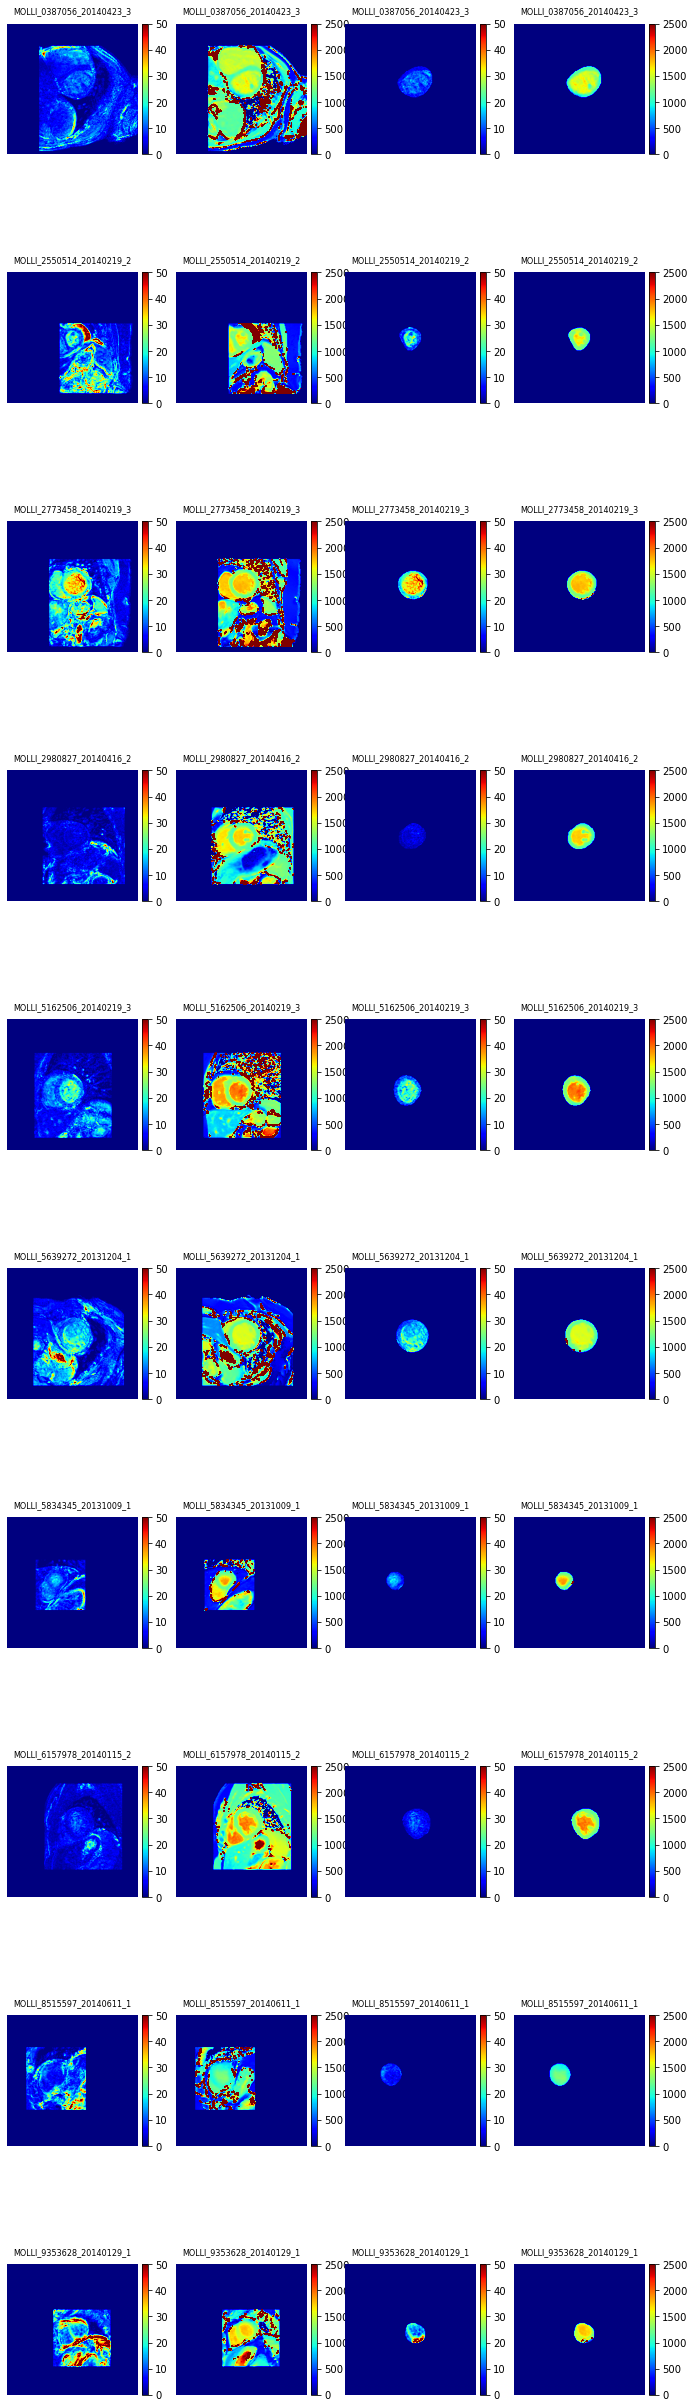

In [16]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import scipy.io
from pathlib import Path
# %matplotlib widget
path = f"{base_path}/t1_SDerr"
# print(path)
fig = plt.figure(figsize=(10,40))
title_font_size=8
title_pad = 10
r1_t1err_square_list = []
r1_t1err_heart_list = []
subject_list = []
for i, file in enumerate(sorted(glob.glob(os.path.join(path, '*.mat')))):
    subject = Path(file).stem
    subject_list.append(subject)
    fd = scipy.io.loadmat(file)
    SD_err = fd['S']
    areamask = fd['areamask']
    heartmask = fd['epi_BW']
    errmap = SD_err * areamask

    r1_t1err_square_list.append(np.mean(errmap[areamask==1]))
    fig.add_subplot(10, 4, 1+i*4)
    ax = plt.gca()
    im = ax.imshow(errmap, cmap='jet', vmin=0, vmax=50)
    ax.axis('off')
    ax.set_title(f"{subject}", fontsize=title_font_size, pad=title_pad)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)

    t1_params_pre = fd['pmap_mse']
    a = t1_params_pre[:, :, 0]
    b = t1_params_pre[:, :, 1]
    c = t1_params_pre[:, :, 2]
    t1map = c * (b - 1)
    fig.add_subplot(10, 4, 2+i*4)
    ax = plt.gca()
    im = ax.imshow(t1map, cmap='jet', vmin=0, vmax=2500)
    ax.axis('off')
    ax.set_title(f"{subject}", fontsize=title_font_size, pad=title_pad)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)

    hearterrmap = SD_err * heartmask
    heartt1map = t1map * heartmask
    r1_t1err_heart_list.append(np.mean(hearterrmap[heartmask==1]))

    fig.add_subplot(10, 4, 3+i*4)
    ax = plt.gca()
    im = ax.imshow(hearterrmap, cmap='jet', vmin=0, vmax=50)
    ax.axis('off')
    ax.set_title(f"{subject}", fontsize=title_font_size, pad=title_pad)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)

    fig.add_subplot(10, 4, 4+i*4)
    ax = plt.gca()
    im = ax.imshow(heartt1map, cmap='jet', vmin=0, vmax=2500)
    ax.axis('off')
    ax.set_title(f"{subject}", fontsize=title_font_size, pad=title_pad)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)

plt.subplots_adjust(left=0.0001,right=0.9, top=0.95, bottom=0.1,)
# plt.subplots_adjust(left=0.0001, right=0.99, top=0.9,
#                         bottom=0.1, wspace=0.01, hspace=0.2)
print(f"Mean of t1err is {np.mean(np.array(r1_t1err_square_list))} and std is {np.std(np.array(r1_t1err_square_list))}")
print(f"Mean of t1err is {np.mean(np.array(r1_t1err_heart_list))} and std is {np.std(np.array(r1_t1err_heart_list))}")
plt.savefig(f"{base_path}/t1_SDerr.png", dpi=300)

### Round 2

In [17]:
r = 2
base_path = f"{root}/round{r}"

#### First Eigen Component percentage

In [18]:
path = f"{base_path}/moved"
r2_pca_changes = []
for file in sorted(glob.glob(os.path.join(path, '*.npy'))):
    vols = np.load(file).transpose(1, 2, 0)
    eig_org, org_K, org_dis = pca(vols, topk=1)
    r2_pca_changes.append(org_dis)
print(f"Mean of Round 2 PCA is {np.mean(np.array(r2_pca_changes))} and std is {np.std(np.array(r2_pca_changes))}")

Mean of Round 2 PCA is 0.7966226601634627 and std is 0.023661249292757487


#### Jacobian Determination

In [19]:
r2_folding_ratio_list = []
r2_mag_det_jac_det_list = []
path = f"{base_path}/warp"
for file in sorted(glob.glob(os.path.join(path, '*.nii'))):
    disp = vxm.py.utils.load_volfile(file).transpose(2, 3, 0, 1)
    folding_ratio, mag_det_jac_det = jacobian(disp)
    r2_folding_ratio_list.append(folding_ratio)
    r2_mag_det_jac_det_list.append(mag_det_jac_det)

print(f"Mean of folding ratio is {np.mean(np.array(r2_folding_ratio_list))}")
print(f"Mean of mag det jac det is {np.mean(np.array(r2_mag_det_jac_det_list))}")

Mean of folding ratio is 0.0
Mean of mag det jac det is 0.0024248522240668535


#### T1 fitting

Mean of t1err is 9.940543743287824 and std is 4.310828481937068
Mean of t1err is 13.590760146901385 and std is 7.07240513713518


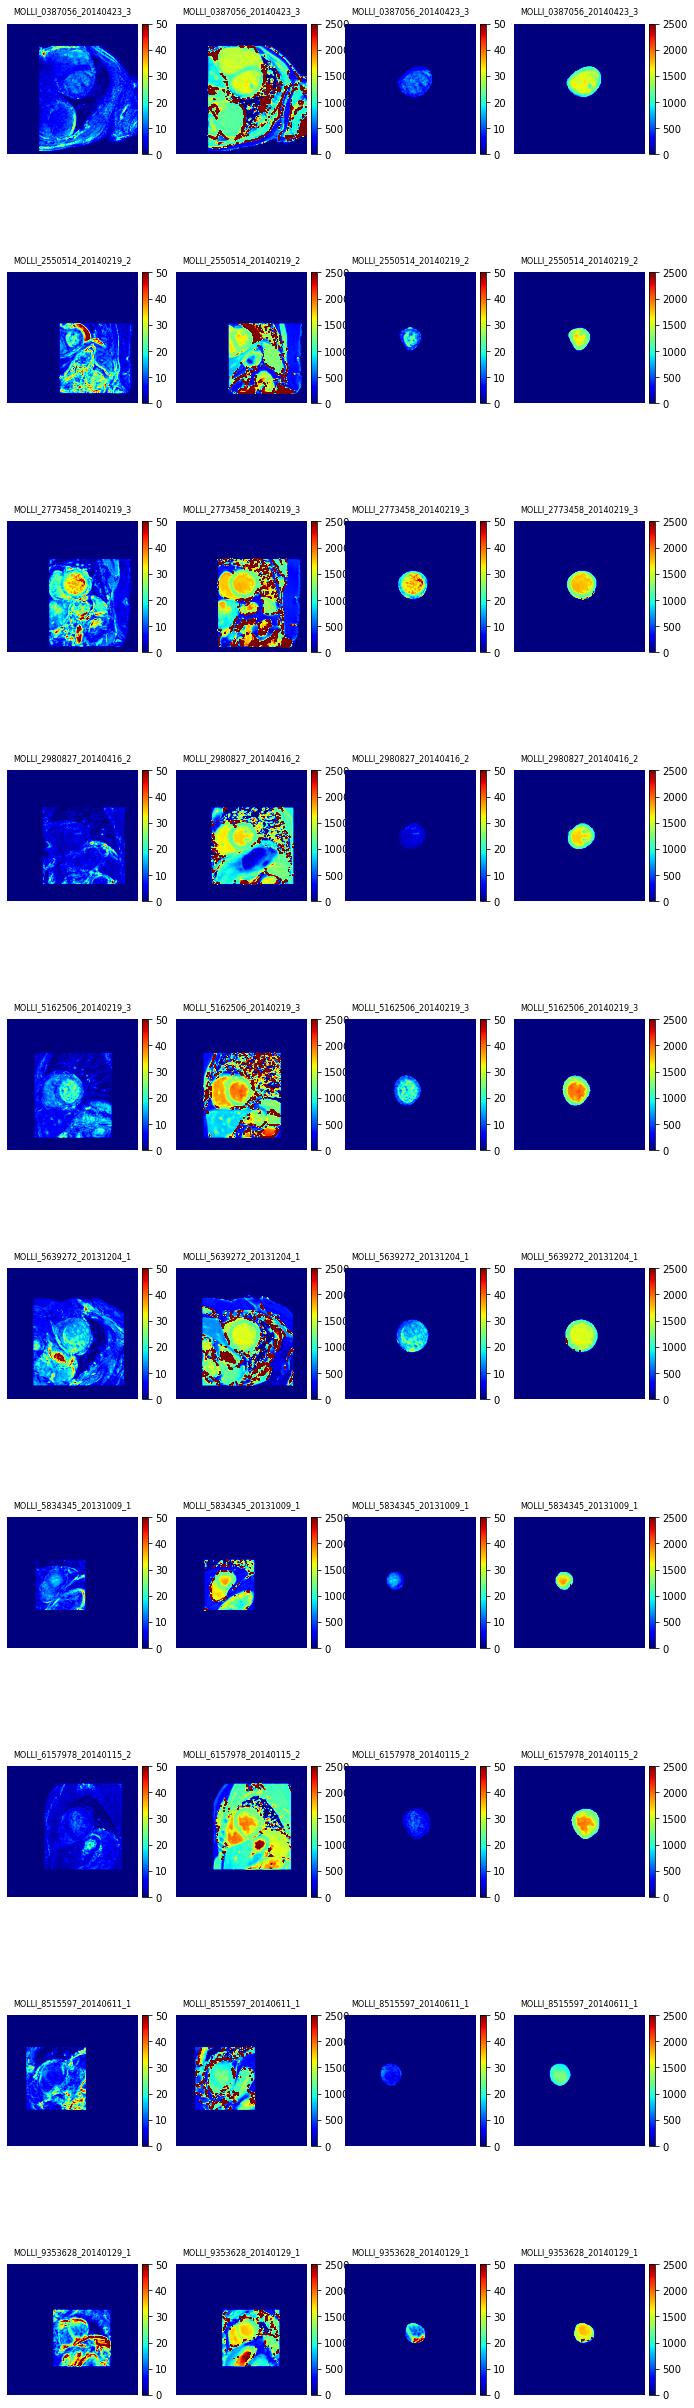

In [20]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import scipy.io
from pathlib import Path
# %matplotlib widget
path = f"{base_path}/t1_SDerr"
# print(path)
fig = plt.figure(figsize=(10,40))
title_font_size=8
title_pad = 10
r2_t1err_square_list = []
r2_t1err_heart_list = []
subject_list = []
for i, file in enumerate(sorted(glob.glob(os.path.join(path, '*.mat')))):
    subject = Path(file).stem
    subject_list.append(subject)
    fd = scipy.io.loadmat(file)
    SD_err = fd['S']
    areamask = fd['areamask']
    heartmask = fd['epi_BW']
    errmap = SD_err * areamask

    r2_t1err_square_list.append(np.mean(errmap[areamask==1]))
    fig.add_subplot(10, 4, 1+i*4)
    ax = plt.gca()
    im = ax.imshow(errmap, cmap='jet', vmin=0, vmax=50)
    ax.axis('off')
    ax.set_title(f"{subject}", fontsize=title_font_size, pad=title_pad)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)

    t1_params_pre = fd['pmap_mse']
    a = t1_params_pre[:, :, 0]
    b = t1_params_pre[:, :, 1]
    c = t1_params_pre[:, :, 2]
    t1map = c * (b - 1)
    fig.add_subplot(10, 4, 2+i*4)
    ax = plt.gca()
    im = ax.imshow(t1map, cmap='jet', vmin=0, vmax=2500)
    ax.axis('off')
    ax.set_title(f"{subject}", fontsize=title_font_size, pad=title_pad)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)

    hearterrmap = SD_err * heartmask
    heartt1map = t1map * heartmask
    r2_t1err_heart_list.append(np.mean(hearterrmap[heartmask==1]))

    fig.add_subplot(10, 4, 3+i*4)
    ax = plt.gca()
    im = ax.imshow(hearterrmap, cmap='jet', vmin=0, vmax=50)
    ax.axis('off')
    ax.set_title(f"{subject}", fontsize=title_font_size, pad=title_pad)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)

    fig.add_subplot(10, 4, 4+i*4)
    ax = plt.gca()
    im = ax.imshow(heartt1map, cmap='jet', vmin=0, vmax=2500)
    ax.axis('off')
    ax.set_title(f"{subject}", fontsize=title_font_size, pad=title_pad)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)

plt.subplots_adjust(left=0.0001,right=0.9, top=0.95, bottom=0.1,)
# plt.subplots_adjust(left=0.0001, right=0.99, top=0.9,
#                         bottom=0.1, wspace=0.01, hspace=0.2)
print(f"Mean of t1err is {np.mean(np.array(r2_t1err_square_list))} and std is {np.std(np.array(r2_t1err_square_list))}")
print(f"Mean of t1err is {np.mean(np.array(r2_t1err_heart_list))} and std is {np.std(np.array(r2_t1err_heart_list))}")
plt.savefig(f"{base_path}/t1_SDerr.png", dpi=300)

### Round 3

In [21]:
r = 3
base_path = f"{root}/round{r}"

#### First Eigen Component percentage

In [22]:
path = f"{base_path}/moved"
r3_pca_changes = []
for file in sorted(glob.glob(os.path.join(path, '*.npy'))):
    vols = np.load(file).transpose(1, 2, 0)
    eig_org, org_K, org_dis = pca(vols, topk=1)
    r3_pca_changes.append(org_dis)
print(f"Mean of Round 2 PCA is {np.mean(np.array(r3_pca_changes))} and std is {np.std(np.array(r3_pca_changes))}")

Mean of Round 2 PCA is 0.7988074197790501 and std is 0.023477756127151354


#### Jacobian Determination

In [23]:
r3_folding_ratio_list = []
r3_mag_det_jac_det_list = []
path = f"{base_path}/warp"
for file in sorted(glob.glob(os.path.join(path, '*.nii'))):
    disp = vxm.py.utils.load_volfile(file).transpose(2, 3, 0, 1)
    folding_ratio, mag_det_jac_det = jacobian(disp)
    r3_folding_ratio_list.append(folding_ratio)
    r3_mag_det_jac_det_list.append(mag_det_jac_det)

print(f"Mean of folding ratio is {np.mean(np.array(r3_folding_ratio_list))}")
print(f"Mean of mag det jac det is {np.mean(np.array(r3_mag_det_jac_det_list))}")

Mean of folding ratio is 0.0
Mean of mag det jac det is 0.002767071593552828


#### T1 fitting

Mean of t1err is 9.843028962437405 and std is 4.248106198201855
Mean of t1err is 13.508889480654588 and std is 6.998822948334339


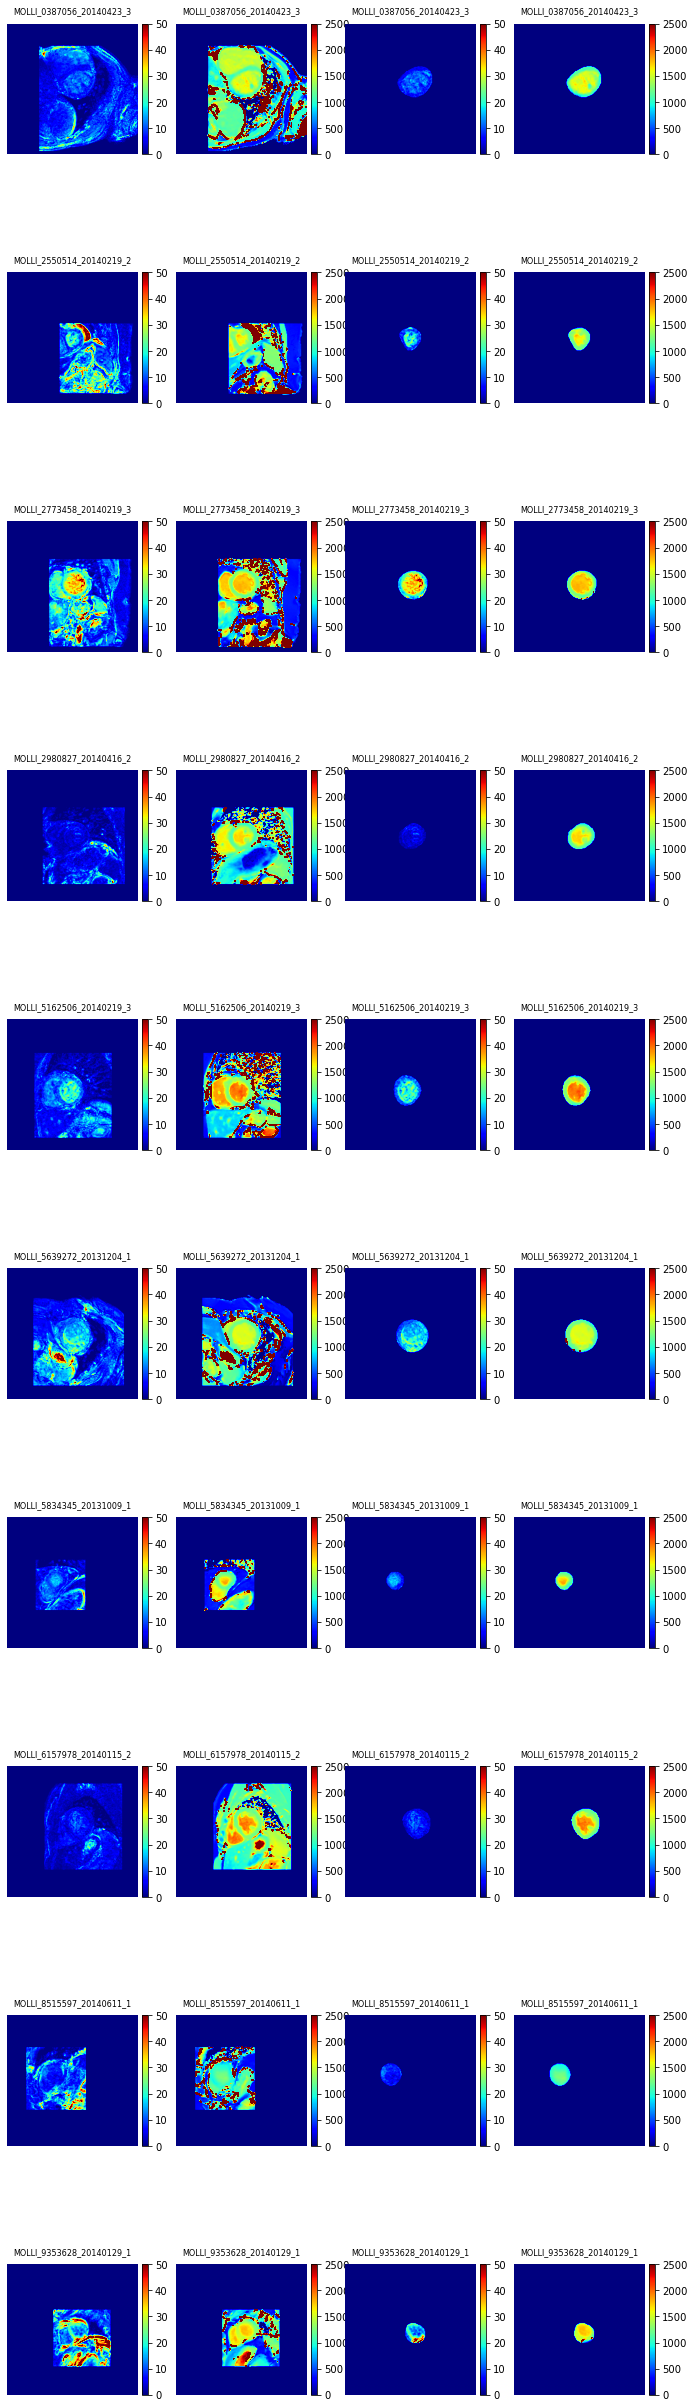

In [24]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import scipy.io
from pathlib import Path
# %matplotlib widget

path = f"{base_path}/t1_SDerr"
# print(path)
fig = plt.figure(figsize=(10,40))
title_font_size=8
title_pad = 10
r3_t1err_square_list = []
r3_t1err_heart_list = []
subject_list = []
for i, file in enumerate(sorted(glob.glob(os.path.join(path, '*.mat')))):
    subject = Path(file).stem
    subject_list.append(subject)
    fd = scipy.io.loadmat(file)
    SD_err = fd['S']
    areamask = fd['areamask']
    heartmask = fd['epi_BW']
    errmap = SD_err * areamask

    r3_t1err_square_list.append(np.mean(errmap[areamask==1]))
    fig.add_subplot(10, 4, 1+i*4)
    ax = plt.gca()
    im = ax.imshow(errmap, cmap='jet', vmin=0, vmax=50)
    ax.axis('off')
    ax.set_title(f"{subject}", fontsize=title_font_size, pad=title_pad)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)

    t1_params_pre = fd['pmap_mse']
    a = t1_params_pre[:, :, 0]
    b = t1_params_pre[:, :, 1]
    c = t1_params_pre[:, :, 2]
    t1map = c * (b - 1)
    fig.add_subplot(10, 4, 2+i*4)
    ax = plt.gca()
    im = ax.imshow(t1map, cmap='jet', vmin=0, vmax=2500)
    ax.axis('off')
    ax.set_title(f"{subject}", fontsize=title_font_size, pad=title_pad)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)

    hearterrmap = SD_err * heartmask
    heartt1map = t1map * heartmask
    r3_t1err_heart_list.append(np.mean(hearterrmap[heartmask==1]))

    fig.add_subplot(10, 4, 3+i*4)
    ax = plt.gca()
    im = ax.imshow(hearterrmap, cmap='jet', vmin=0, vmax=50)
    ax.axis('off')
    ax.set_title(f"{subject}", fontsize=title_font_size, pad=title_pad)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)

    fig.add_subplot(10, 4, 4+i*4)
    ax = plt.gca()
    im = ax.imshow(heartt1map, cmap='jet', vmin=0, vmax=2500)
    ax.axis('off')
    ax.set_title(f"{subject}", fontsize=title_font_size, pad=title_pad)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)

plt.subplots_adjust(left=0.0001,right=0.9, top=0.95, bottom=0.1,)
# plt.subplots_adjust(left=0.0001, right=0.99, top=0.9,
#                         bottom=0.1, wspace=0.01, hspace=0.2)
print(f"Mean of t1err is {np.mean(np.array(r3_t1err_square_list))} and std is {np.std(np.array(r3_t1err_square_list))}")
print(f"Mean of t1err is {np.mean(np.array(r3_t1err_heart_list))} and std is {np.std(np.array(r3_t1err_heart_list))}")
plt.savefig(f"{base_path}/t1_SDerr.png", dpi=300)

### Summary

In [25]:
import pandas as pd
df = pd.DataFrame()
df['Cases'] = subject_list
df['Raw Square T1err'] = orig_t1err_square_list
df['R1 Square T1err'] = r1_t1err_square_list
df['R2 Square T1err'] = r2_t1err_square_list
df['R3 Square T1err'] = r3_t1err_square_list
df['Square T1err diff'] = (df['Raw Square T1err'] - df['R3 Square T1err']) / df['Raw Square T1err']
df['Raw Heart T1err'] = orig_t1err_heart_list
df['R1 Heart T1err'] = r1_t1err_heart_list
df['R2 Heart T1err'] = r2_t1err_heart_list
df['R3 Heart T1err'] = r3_t1err_heart_list
df['Heart T1err diff'] = (df['Raw Heart T1err'] - df['R3 Heart T1err']) / df['Raw Heart T1err']
df

,Cases,Raw Square T1err,R1 Square T1err,R2 Square T1err,R3 Square T1err,Square T1err diff,Raw Heart T1err,R1 Heart T1err,R2 Heart T1err,R3 Heart T1err,Heart T1err diff
0,MOLLI_0387056_20140423_3,7.539072,7.164823,7.184224,7.113728,0.056419,9.731935,9.468720,9.299165,9.234812,0.051082
1,MOLLI_2550514_20140219_2,12.360840,11.950112,11.892691,11.754735,0.049034,14.576425,14.310972,14.280946,14.147773,0.029407
2,MOLLI_2773458_20140219_3,13.635501,12.853943,12.588063,12.545436,0.079943,28.671655,28.678243,28.239749,28.339058,0.011600
3,MOLLI_2980827_20140416_2,5.785524,5.281986,5.201444,5.127748,0.113693,3.958349,3.955771,4.052812,4.199225,-0.060853
4,MOLLI_5162506_20140219_3,8.644283,7.968601,7.830708,7.736210,0.105049,17.141349,16.663565,16.405188,16.182896,0.055915
5,MOLLI_5639272_20131204_1,11.297461,10.414895,10.283304,10.212827,0.096007,17.010539,16.670998,16.384424,16.279367,0.042983
6,MOLLI_5834345_20131009_1,10.555566,8.468087,8.270753,8.314422,0.212319,12.637421,11.394061,11.024569,11.112645,0.120656
7,MOLLI_6157978_20140115_2,5.011841,4.706444,4.612319,4.573129,0.087535,6.933013,6.780940,6.659051,6.628698,0.043894
8,MOLLI_8515597_20140611_1,12.463286,11.401182,11.231080,11.023437,0.115527,7.736930,7.566460,7.620626,7.599044,0.017822
9,MOLLI_9353628_20140129_1,23.435838,20.935444,20.310851,20.028617,0.145385,23.772507,22.310932,21.941070,21.365379,0.101257


In [26]:
df.describe()

,Raw Square T1err,R1 Square T1err,R2 Square T1err,R3 Square T1err,Square T1err diff,Raw Heart T1err,R1 Heart T1err,R2 Heart T1err,R3 Heart T1err,Heart T1err diff
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,11.072921,10.114552,9.940544,9.843029,0.106091,14.217012,13.780066,13.590760,13.508889,0.041376
std,5.232358,4.694312,4.544012,4.477897,0.046938,7.743300,7.601750,7.454970,7.377407,0.049689
min,5.011841,4.706444,4.612319,4.573129,0.049034,3.958349,3.955771,4.052812,4.199225,-0.060853
25%,7.815375,7.365768,7.345845,7.269348,0.081841,8.235682,8.042025,8.040261,8.007986,0.020718
50%,10.926513,9.441491,9.277028,9.263625,0.100528,13.606923,12.852516,12.652757,12.630209,0.043439
75%,12.437674,11.812880,11.727288,11.571911,0.115069,17.108646,16.669140,16.399997,16.255249,0.054706
max,23.435838,20.935444,20.310851,20.028617,0.212319,28.671655,28.678243,28.239749,28.339058,0.120656


In [27]:
df_2 = pd.DataFrame()
df_2['Cases'] = subject_list
df_2['Raw PCA'] = orig_pca_changes
df_2['R1 PCA'] = r1_pca_changes
df_2['R2 PCA'] = r2_pca_changes
df_2['R3 PCA'] = r3_pca_changes
df_2['R1 Det'] = r1_mag_det_jac_det_list
df_2['R2 Det'] = r2_mag_det_jac_det_list
df_2['R3 Det'] = r3_mag_det_jac_det_list
df_2['R1 Fold ratio'] = r1_folding_ratio_list
df_2['R2 Fold ratio'] = r2_folding_ratio_list
df_2['R3 Fold ratio'] = r3_folding_ratio_list
df_2

,Cases,Raw PCA,R1 PCA,R2 PCA,R3 PCA,R1 Det,R2 Det,R3 Det,R1 Fold ratio,R2 Fold ratio,R3 Fold ratio
0,MOLLI_0387056_20140423_3,0.806249,0.814215,0.815603,0.816613,0.002469,0.001746,0.001431,0.0,0.0,0.0
1,MOLLI_2550514_20140219_2,0.792254,0.798875,0.801485,0.803485,0.003482,0.002513,0.002914,0.0,0.0,0.0
2,MOLLI_2773458_20140219_3,0.773361,0.779731,0.782695,0.784498,0.003252,0.002571,0.002993,0.0,0.0,0.0
3,MOLLI_2980827_20140416_2,0.813012,0.818807,0.822809,0.825825,0.003285,0.002441,0.002918,0.0,0.0,0.0
4,MOLLI_5162506_20140219_3,0.787799,0.792674,0.795299,0.797084,0.003249,0.002516,0.003071,0.0,0.0,0.0
5,MOLLI_5639272_20131204_1,0.773060,0.778019,0.780979,0.783335,0.002830,0.002464,0.002734,0.0,0.0,0.0
6,MOLLI_5834345_20131009_1,0.757565,0.767185,0.770689,0.773487,0.003458,0.002451,0.002873,0.0,0.0,0.0
7,MOLLI_6157978_20140115_2,0.839774,0.843166,0.845731,0.847553,0.003004,0.002473,0.002765,0.0,0.0,0.0
8,MOLLI_8515597_20140611_1,0.770515,0.779375,0.782861,0.785875,0.003369,0.002625,0.003015,0.0,0.0,0.0
9,MOLLI_9353628_20140129_1,0.754133,0.764920,0.768076,0.770319,0.003372,0.002447,0.002958,0.0,0.0,0.0


In [28]:
df_2.describe()

,Raw PCA,R1 PCA,R2 PCA,R3 PCA,R1 Det,R2 Det,R3 Det,R1 Fold ratio,R2 Fold ratio,R3 Fold ratio
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.0,10.0,10.0
mean,0.786772,0.793697,0.796623,0.798807,0.003177,0.002425,0.002767,0.0,0.0,0.0
std,0.026789,0.025174,0.024941,0.024748,0.000320,0.000246,0.000481,0.0,0.0,0.0
min,0.754133,0.764920,0.768076,0.770319,0.002469,0.001746,0.001431,0.0,0.0,0.0
25%,0.771151,0.778358,0.781408,0.783626,0.003065,0.002448,0.002792,0.0,0.0,0.0
50%,0.780580,0.786202,0.789080,0.791480,0.003268,0.002469,0.002916,0.0,0.0,0.0
75%,0.802750,0.810380,0.812074,0.813331,0.003371,0.002515,0.002984,0.0,0.0,0.0
max,0.839774,0.843166,0.845731,0.847553,0.003482,0.002625,0.003071,0.0,0.0,0.0


In [29]:
df_2.describe()

,Raw PCA,R1 PCA,R2 PCA,R3 PCA,R1 Det,R2 Det,R3 Det,R1 Fold ratio,R2 Fold ratio,R3 Fold ratio
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.0,10.0,10.0
mean,0.786772,0.793697,0.796623,0.798807,0.003177,0.002425,0.002767,0.0,0.0,0.0
std,0.026789,0.025174,0.024941,0.024748,0.000320,0.000246,0.000481,0.0,0.0,0.0
min,0.754133,0.764920,0.768076,0.770319,0.002469,0.001746,0.001431,0.0,0.0,0.0
25%,0.771151,0.778358,0.781408,0.783626,0.003065,0.002448,0.002792,0.0,0.0,0.0
50%,0.780580,0.786202,0.789080,0.791480,0.003268,0.002469,0.002916,0.0,0.0,0.0
75%,0.802750,0.810380,0.812074,0.813331,0.003371,0.002515,0.002984,0.0,0.0,0.0
max,0.839774,0.843166,0.845731,0.847553,0.003482,0.002625,0.003071,0.0,0.0,0.0
